In [30]:
from parcels.scripts import *
from datetime import timedelta, datetime
from os.path import join
from config.params import Opts
from config.MainConfig import get_config
import sys
import os
import gc
import numpy as np
from parcels import FieldSet, Field, JITParticle, ScipyParticle, ParticleSet, ErrorCode, AdvectionRK4, plotTrajectoriesFile
from downloads.io_hycom import read_files, add_Kh
from mykernels.custom_particles import LitterParticle
from mykernels.wl_kernels import AdvectionRK4COAPS, BrownianMotion2D
import time
from distutils.util import strtobool
from io_utils.io_common import read_test_data_files, parse_drifters_dates
import pandas as pd


In [44]:
print("Defining parameters")
time_format = "%Y-%m-%d:%H"
time_format_red = "%Y_%m_%d"

start_date = datetime.strptime(F"2021-05-30:00:00:00", "%Y-%m-%d:%H:%M:%S")
end_date = datetime.strptime(F"2021-06-10:00:00:00", "%Y-%m-%d:%H:%M:%S")
name = "TestOZ.nc"
config = get_config()
run_name = "first test"

kh = 1
output_file = join(config[Opts.drifters_pred_folder], name)
print("Done!")


Defining parameters
Done!


In [45]:
print("Reading data!")

# This one should read all the proper file names for currents, winds, waves
# file_names = read_files(base_folder, years, wind=winds, start_date=start_date, end_date=end_date)
current_files, wind_files, wave_files = read_test_data_files(config)

# print("Reading drifter locations.....")
# file_drifters = join(config[Opts.drifters_obs_folder],os.listdir(config[Opts.drifters_obs_folder])[0])
# ds = pd.read_csv(file_drifters, header=0, names=['sigwaveheight','peakperiod', 'meanperiod','peakdirection','dirspread', 'meandirection',
#                                                  'meandirectionspread','time','lat','lon','epoch','id'],
#                                          parse_dates=['time'], date_parser=parse_drifters_dates)
# bydrifter = ds.groupby('id')
# lat0 = []
# lon0 = []
# # Obtains the positions that are closest to the desired start time
# for id, c_drifter in bydrifter:
#     lat0.append(c_drifter.iloc[np.where(min(c_drifter['time'] - start_date))[0]]['lat'].item())
#     lon0.append(c_drifter.iloc[np.where(min(c_drifter['time'] - start_date))[0]]['lon'].item())

lat0 = [34.95782, 40.3183, 39.48998, 35.61692, 37.93162, 36.55655, 24.6545, 36.88377, 39.44885, 39.65353, 32.93048, 37.38632, 41.3903, 25.63072, 30.87312, 29.42992, 23.91555, 28.71653, 29.97938, 33.47635, 29.98733, 24.3495, 30.17848, 25.56707, 28.6618, 26.5982, 34.52145, 21.65822, 34.4552, 25.05182, 36.54267, 38.66585, 23.94418, 39.76413, 28.4145, 37.80082, 39.34975, 36.71827, 35.85277, 29.93062, 23.45207, 35.60602, 32.422, 35.77113, 33.13698, 41.71518, 32.36253, 40.63743, 36.04395, 39.85897, 30.53288, 30.03725, 29.9231, 29.84832, 31.56732, 29.05162, 29.1147, 32.1278, 31.98773, 33.93122, 40.28842, 30.89012, 35.22377, 37.83523, 39.26407, 33.28622, 37.63468, 34.86187, 38.09545, 37.85067, 36.20378, 39.88838, 38.05873, 37.77892, 38.60998, 39.32322, 30.08607, 32.71038, 25.45098, 28.36712, 34.78413, 27.47555, 28.84338, 29.1741, 27.24477, 24.03797, 29.80843, 29.81335, 26.20822, 32.76763, 35.75945, 35.92923, 36.37027, 36.22468]
lon0 = [290.06765, 312.18885, 303.47495, 294.93212, 297.84937, 295.95953, 294.17883, 291.62395, 294.04315, 303.99222, 298.29075, 299.7352, 305.08572, 295.79358, 330.38032, 296.74118, 294.95298, 317.45308, 326.48907, 323.71503, 319.3997, 294.82283, 342.34468, 295.16588, 320.5996, 293.4356, 294.79192, 294.89302, 315.46578, 293.30145, 292.45522, 299.56768, 293.03188, 292.57973, 292.99267, 314.39877, 298.28168, 296.2156, 316.8952, 294.76782, 293.14903, 290.50917, 316.03933, 293.77588, 314.99035, 322.35085, 312.41787, 293.28753, 308.261, 325.82982, 335.84675, 330.49413, 319.92027, 344.52298, 332.2308, 298.93977, 335.2463, 287.86752, 334.15242, 293.9958, 308.59698, 311.0839, 292.28803, 316.62287, 313.26358, 297.6898, 299.43807, 294.42412, 308.35202, 295.14303, 306.18385, 301.938, 298.87635, 303.61933, 304.14708, 309.17353, 284.66853, 333.84117, 299.71415, 297.33323, 330.71187, 314.43237, 314.2787, 329.00898, 300.6933, 291.4846, 326.94635, 339.80128, 305.18052, 320.24412, 323.5712, 320.41007, 327.61123, 326.34667]

# Reading all at the same time
print("Reading all fields.....", flush=True)
file_names = {'U': current_files, 'V': current_files, 'U_wind': wind_files, 'V_wind': wind_files}
variables = {'U': 'surf_u', 'V': 'surf_v', 'U_wind':'U', 'V_wind':'V'}
dimensions = {}
dimensions['U'] = {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}
dimensions['V'] = {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}
dimensions['U_wind'] = {'lat': 'lat', 'lon': 'lon', 'time': 'time'}
dimensions['V_wind'] = {'lat': 'lat', 'lon': 'lon', 'time': 'time'}
all_fieldset = FieldSet.from_netcdf(file_names, variables, dimensions, allow_time_extrapolation=True)
# Reading ONLY currents
# print("Reading currents.....", flush=True)
# variables = {'U': 'surf_u', 'V': 'surf_v'}
# dimensions = {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}
# all_fieldset = FieldSet.from_netcdf(current_files, variables, dimensions, allow_time_extrapolation=True)

# Reading waves
# print("Reading waves.....", flush=True)
# variables = {'U': 'surf_u', 'V': 'surf_v'}
# dimensions = {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}
# waves_field = Field.from_netcdf(wave_files, variables, dimensions, allow_time_extrapolation=True)
# all_fieldset.add_field(waves_field, 'waves')
print("Done!")

Reading data!
Reading all fields.....
Done!


In [46]:
print("Displaying the initial fields")
# all_fieldset.U.show()
# all_fieldset.V.show()
# all_fieldset.U_wind.show()
# all_fieldset.V_wind.show()
print("Done!")



Displaying the initial fields
Done!


In [47]:
print("Configuring model and adding addtional fields!")
# -------  Making syntetic diffusion coefficient
U_grid = all_fieldset.U.grid
lat = U_grid.lat
lon = U_grid.lon
# Getting proporcional size by degree
# print("Adding diffusion .....")
# add_Kh(all_fieldset, lat, lon, kh)

print("Setting up everything.....")
particle_class = JITParticle
# particle_class = ScipyParticle
pset = ParticleSet(fieldset=all_fieldset, pclass=particle_class, lon=lon0, lat=lat0, time=0)
out_parc_file = pset.ParticleFile(name=output_file, outputdt=config[Opts.output_freq])
t = time.time()

print(F"Adding kernels...")
kernels = pset.Kernel(AdvectionRK4)
# kernels = pset.Kernel(AdvectionRK4COAPS)
# kernels += pset.Kernel(BrownianMotion2D)
print("Done!")


Configuring model and adding addtional fields!
Setting up everything.....
Adding kernels...
Done!


In [48]:
# dt = config[Opts.dt]
# run_time = timedelta(seconds=(end_date - start_date).total_seconds())
dt = timedelta(hours=1)
run_time = timedelta(days=10)
print(F"Running with {pset.size} number of particles for {run_time} with dt:{dt}", flush=True)
pset.execute(kernels, runtime=run_time, dt=dt, output_file=out_parc_file)

print(F"Done time={time.time()-t}.....")

print(F"Saving output to {output_file}!!!!!")
# domain = {'N': 31, 'S': 16, 'E': -76, 'W': -98}
# pset.show(field=all_fieldset.U, domain=domain)  # Draw current particles
out_parc_file.export() # Save trajectories to file
print("Done")


Running with 94 number of particles for 10 days, 0:00:00 with dt:1:00:00


INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib4231172488a5cd99df3812ae322175cc_0.so


Done time=8.323447465896606.....
Saving output to /data/DARPA/LOCALDATA/drifters_predict/TestOZ.nc!!!!!
Done


Making plots


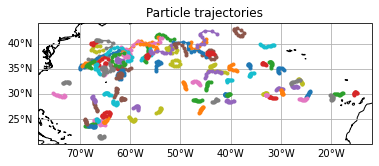

Done!


In [49]:
print("Making plots")
plotTrajectoriesFile(output_file, mode='2d') # Plotting trajectories
# out_parc_file.close()
# del pset
# del kernels
# del all_fieldset
# # plotTrajectoriesFile(output_file) # Plotting trajectories
# print("Forcing gc.collect")
# gc.collect()
print("Done!")